In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import time
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
train_df = pd.read_csv("mitbih_train.csv", header=None)
test_df = pd.read_csv("mitbih_test.csv", header=None)

X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

In [83]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) 
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# el aumento de batch aumenta el ovesampling

In [84]:
class ECGCNN(nn.Module):
    def __init__(self, num_classes):
        super(ECGCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.flatten = nn.Flatten()

        conv_output_length = 187 // 4 

        self.fc1 = nn.Linear(32 * conv_output_length, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        return self.fc2(x)

In [85]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Usando GPU:", torch.cuda.get_device_name(0))

# semilla para experimentos     
# seed = 42
# torch.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(seed)

model = ECGCNN(num_classes=len(np.unique(y_train))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Usando GPU: NVIDIA GeForce RTX 4060


In [86]:
start_time_total = time.time()

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

model = ECGCNN(num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
start_time_total = time.time()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
#mas de 5 epocas dan oversampling


Epoch 1/5 - Loss: 0.2974
Epoch 2/5 - Loss: 0.1536
Epoch 3/5 - Loss: 0.1271
Epoch 4/5 - Loss: 0.1119
Epoch 5/5 - Loss: 0.1028



Evaluando modelo...

Accuracy: 0.9695

Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     18118
           1       0.85      0.63      0.72       556
           2       0.91      0.92      0.91      1448
           3       0.85      0.49      0.62       162
           4       0.99      0.92      0.96      1608

    accuracy                           0.97     21892
   macro avg       0.91      0.79      0.84     21892
weighted avg       0.97      0.97      0.97     21892



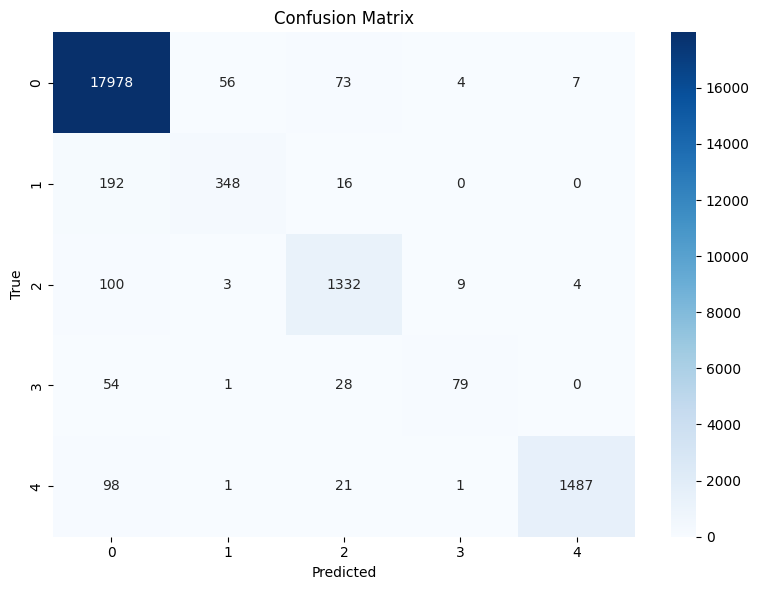


Tiempo de evaluación: 0.00 segundos
Tiempo total de ejecución: 13.66 segundos


In [87]:
print("\nEvaluando modelo...")

model.eval()

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

eval_start_time = time.time()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

eval_time = time.time() - eval_start_time

y_pred = predicted.cpu().numpy()
y_true = y_test_tensor.cpu().numpy()

accuracy = np.mean(y_pred == y_true)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred))

labels = sorted(set(y_true))
conf_mat = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

total_time = time.time() - start_time_total
print(f"\nTiempo de evaluación: {eval_time:.2f} segundos")
print(f"Tiempo total de ejecución: {total_time:.2f} segundos")


In [88]:
torch.save(model.state_dict(), "ecg_model_cnn.pth")
print("Modelo guardado como 'ecg_model_cnn.pth'")

Modelo guardado como 'ecg_model_cnn.pth'
